<a href="https://colab.research.google.com/github/Jp431/OilPricePredictor/blob/main/Oil_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this notebook

I am using the available data to predict Brent Oil Prices. Predicting on stochastic data--randomly determined--while incredibly hard can be optmize to a certain point using NN. While the accuracy is not very high further optimization in its accuracy can be achieved by a deeper understanding of the variables that compose the price of this dataset.

In [ ]:
import h5py
import keras
import requests
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import load_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Dropout, Activation

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks - studies/Random Projects/data/BrentOilPrices.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


## 1. Exploratory Data Analysis (EDA)**texte en gras**
Most machine learning models do not handle missing values very well so it is common practise to check for it before going any further.

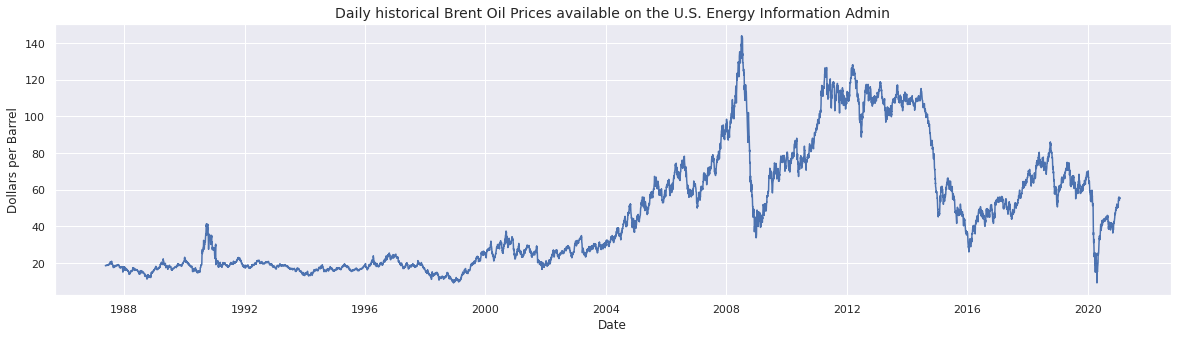

In [ ]:
sns.set_theme(style="darkgrid")
df.isnull().sum()
plt.figure(figsize=(20,5))
sns.lineplot(x="Date", y="Price", data=df)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.show()

### Data quality check
Checking the dataset as a whole using summary statistics.

In [ ]:
df.describe()

,Price
count,8554.000000
mean,46.352962
std,32.165282
min,9.100000
25%,18.850000
50%,33.240000
75%,66.210000
max,143.950000


## 2. Build of technical indicators
These indicators are a set of mathematical calculation that will be based on our 'oil price' they will help us to predict--hopefully--where the price is going.

### 2.1 MA - Moving Average
A Moving average is, often called *Simple Moving Average* or SMA is a average that considers a time period to its calculation. The formula is as follows:$$MA=\frac{A_{1}+A_{2}+A_{3}+...A_{n}}{n}$$ 
Where: A=Average in period *n* and *n* = Number of periods

***

### 2.2 EMA - Exponential Moving Average
This indicator is called Exponential Moving Average, what set its appart is that the most recent days have a higher importance to the formulas. This is often use to predict buy/sell in the stock market.

$$EMA_{Today} = \begin{pmatrix}Value_{Today} * \begin{pmatrix}\frac{smoothing} {1+Days}\end{pmatrix}\end{pmatrix} 
                +EMA_{Yesterday} * \begin{pmatrix}1-\begin{pmatrix}\frac{smoothing} {1+Days}\end{pmatrix}\end{pmatrix}
                $$For the smoothing factor we will set its default value: 2.
$$
***


### 2.3 MACD - Moving Average convergence-divergence 
MACD the difference two EMA a short-period (fast) EMA and a long-period (slow)  EMA:$$MACD = EMA_{1} - EMA_{2}$$
The usual values for EMA 1 is 12 and the EMA 2 is 26.
***

### 2.4 Bollinger Bands
This bands are useful to predict the volatily of a given item, allow us to see if there is anything that goes outside what is considere "normal behavior".
There are two bollinger bands, one in the upper part of the chart, called *upper band* and one in the lower part called *lower band*:$$Upper band: MA_{21 days} + (\sigma MA_{21 days}x * 2)$$
$$Upper band: MA_{21 days} - (\sigma MA_{21 days}x * 2)$$ Where: x is the variable you are using as a predictor.

In [ ]:
# Creating a simple moving average for 7 and 21 days
df['ma7'] = df.Price.rolling(window=7).mean()
df['ma21'] = df.Price.rolling(window=21).mean()

# Creating the EMA
df['ema12'] = df.Price.ewm(span=12).mean().fillna(0)
df['ema26'] = df.Price.ewm(span=26).mean().fillna(0)
df['macd'] = df.ema12 - df.ema26

#The variables below are used for Bollinger Bands.
window=21
no_std = 2
rolling_mean = df.Price.rolling(window).mean()
rolling_std = df.Price.rolling(window).std()
df['bollinger_low'] = (rolling_mean - (rolling_std * no_std)).fillna(0)
df['bollinger_high'] = (rolling_mean + (rolling_std * no_std)).fillna(0)
df['ema'] = df.Price.ewm(com=0.5).mean()
df['momentum'] =  df.Price - 1

df.head()

,Price,ma7,ma21,ema12,ema26,macd,bollinger_low,bollinger_high,ema,momentum
Date,,,,,,,,,,
1987-05-20,18.63,NaN,NaN,18.630000,18.630000,0.000000,0.0,0.0,18.630000,17.63
1987-05-21,18.45,NaN,NaN,18.532500,18.536538,-0.004038,0.0,0.0,18.495000,17.45
1987-05-22,18.55,NaN,NaN,18.539330,18.541375,-0.002045,0.0,0.0,18.533077,17.55
1987-05-25,18.60,NaN,NaN,18.558481,18.557764,0.000717,0.0,0.0,18.578250,17.60
1987-05-26,18.63,NaN,NaN,18.577913,18.574516,0.003397,0.0,0.0,18.612893,17.63


##  3. Machine learning
Now the actual prediction using machine learning begins to take shape. As stated earlier, machine learning do not handle missing values very well, but it also has a problem with outliers. To Fix dis we will use a scaler.

#### 3.1. Data Normalization
A scaler, in machine learning is a tool that uses a range and set all values that you pass to it within data range.
The code belows handles that.

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df.Price.values.reshape(-1, 1))
dataset[0:10]

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       [0.07044865],
       [0.07067112],
       [0.07044865],
       [0.07044865],
       [0.07030033],
       [0.07081943],
       [0.0710419 ]])

#### 3.2. Split of the data into training and testing
In order to test the effectiveness of our model we need to test it in the data that we already have.
To do so, you usually uses a *train_test_split* approach where 70% of our data is used for training and 30% for testing.

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 8554 >> Train length: 5987 || Test Length: 2567'

### 3.3 Functions
The idea of this step is to make sure the data fed into the model is clean as possible to avoid any deviations and increase accuracy

The function belows handles the data transformation of the training and test data so we can load it into our model, since LTMS prefere matrixes.

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (5971, 15) || y_train: (5971,) || X_test: (2551, 15) || y_test: (2551,)'

We can now check our reshaped dataset.

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (5971, 1, 15) || y_train: (5971,) || X_test: (2551, 1, 15) || y_test: (2551,)'

## 4. LSTM

This is the model *itself* the Long-Short Term Memory method "remembers the past" and use it to predict the future value, this model works in conjunction with the technical indicator of the second step, thus making sure that we can make accurate predictions even when there are outliers.

In [ ]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
5971/5971 - 12s - loss: 4.2749e-04
Epoch 2/20
5971/5971 - 9s - loss: 2.0012e-04
Epoch 3/20
5971/5971 - 8s - loss: 1.5919e-04
Epoch 4/20
5971/5971 - 9s - loss: 1.4795e-04
Epoch 5/20
5971/5971 - 9s - loss: 1.3248e-04
Epoch 6/20
5971/5971 - 9s - loss: 1.2144e-04
Epoch 7/20
5971/5971 - 10s - loss: 1.2476e-04
Epoch 8/20
5971/5971 - 10s - loss: 1.2230e-04
Epoch 9/20
5971/5971 - 8s - loss: 1.1245e-04
Epoch 10/20
5971/5971 - 9s - loss: 1.0475e-04
Epoch 11/20
5971/5971 - 9s - loss: 1.0708e-04
Epoch 12/20
5971/5971 - 9s - loss: 1.1099e-04
Epoch 13/20
5971/5971 - 10s - loss: 1.0002e-04
Epoch 14/20
5971/5971 - 10s - loss: 1.0111e-04
Epoch 15/20
5971/5971 - 9s - loss: 9.6922e-05
Epoch 16/20
5971/5971 - 9s - loss: 9.8556e-05
Epoch 17/20
5971/5971 - 9s - loss: 9.6015e-05
Epoch 18/20
5971/5971 - 9s - loss: 9.4261e-05
Epoch 19/20
5971/5971 - 10s - loss: 9.4227e-05
Epoch 20/20
5971/5971 - 11s - loss: 9.2971e-05


In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.46 RMSE
Test Score: 2.46 RMSE


### 4.1 Result output

As seen in the step above the result on the training dataset has an error below 2% and the Test score--the unseen data--has an error below 3% meaning that on average any prediction will have a 97% accuracy.

The last step (below) shows, in a visual manner how the predicted values match to their baseline values.

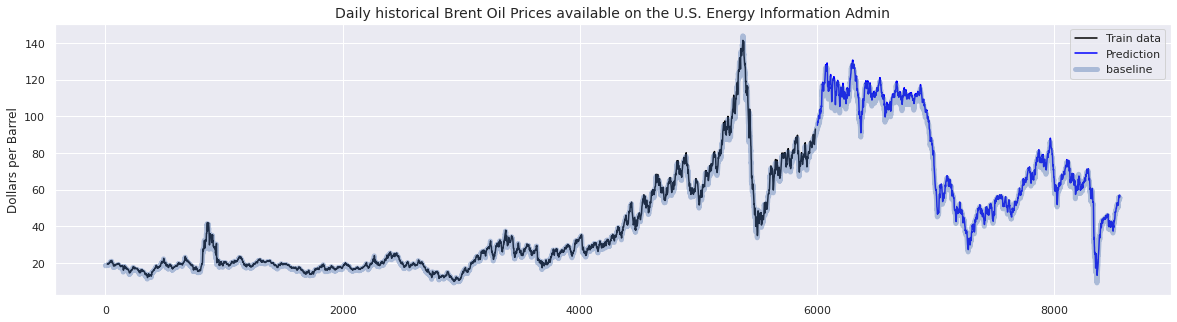

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='black', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(min_max_scaler.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()